## AQ1601 Acrobat Basic Data

In [48]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

### connecting to erddap and retrieving and basic information

In [49]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='acrobat'))

In [50]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 2 tabledap, 0 griddap, and 0 wms endpoints.'

In [51]:
datasets = df['Dataset ID'].values
print(datasets)

['erddap_AQ1601_Acrobat' 'erddap_OS1701L1_Acrobat']


In [52]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in datasets]
print(variables)

[['latitude', 'Conductivity', 'time', 'longitude', 'Salinity', 'depth'], ['oxygen_airsaturation', 'latitude', 'Conductivity', 'time', 'longitude', 'Salinity', 'depth']]


### retrieving erddap and plotting data

In [53]:
constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = [
 'Temperature',
 'Conductivity',
 'Salinity', 
 'depth',
 'latitude',
 'longitude',
 'time',
 'eng_460nm_counts'
]

variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in erddap_AQ1601_Acrobat:
trajectory_id,record_number,Temperature,depth,eng_460nm_counts,Conductivity,longitude,Salinity,eng_700nm_counts,time,latitude,eng_695nm_counts,SigmaT,speed_over_ground
Variables in erddap_OS1701L1_Acrobat:
trajectoryid,record_number,Temperature_Optode,Temperature,depth,eng_460nm_counts,Conductivity,longitude,Salinity,eng_700nm_counts,oxygen_concentration,time,latitude,eng_695nm_counts,SigmaT,oxygen_airsaturation,speed_over_ground


In [54]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in ['erddap_AQ1601_Acrobat','erddap_OS1701L1_Acrobat']:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            e.variables=variables
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

erddap_AQ1601_Acrobat
erddap_OS1701L1_Acrobat


#### Apply EcoTriplet Cal factors

In [71]:
for cruise, df in dfs.items():
    SF = 0.0186
    darkcounts = 54
    df['Chlorophyl'] = SF * (df['eng_695nm_counts'] - darkcounts)

### Plot using GMT-Python

In [56]:
import gmt

In [57]:
fig1 = gmt.Figure()

fig1.coast(region=[-175, -155, 69, 75], projection='B-165/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [58]:
#color by year
clist={'erddap_AQ1601_Acrobat':'red',
       'erddap_OS1701L1_Acrobat':'black'}

for cruise, df in dfs.items():
    #choose temp boundaries
    fig1.plot(x=df.longitude, y=df.latitude, color=clist[cruise], style='c0.05c')


### Acrobat Transits

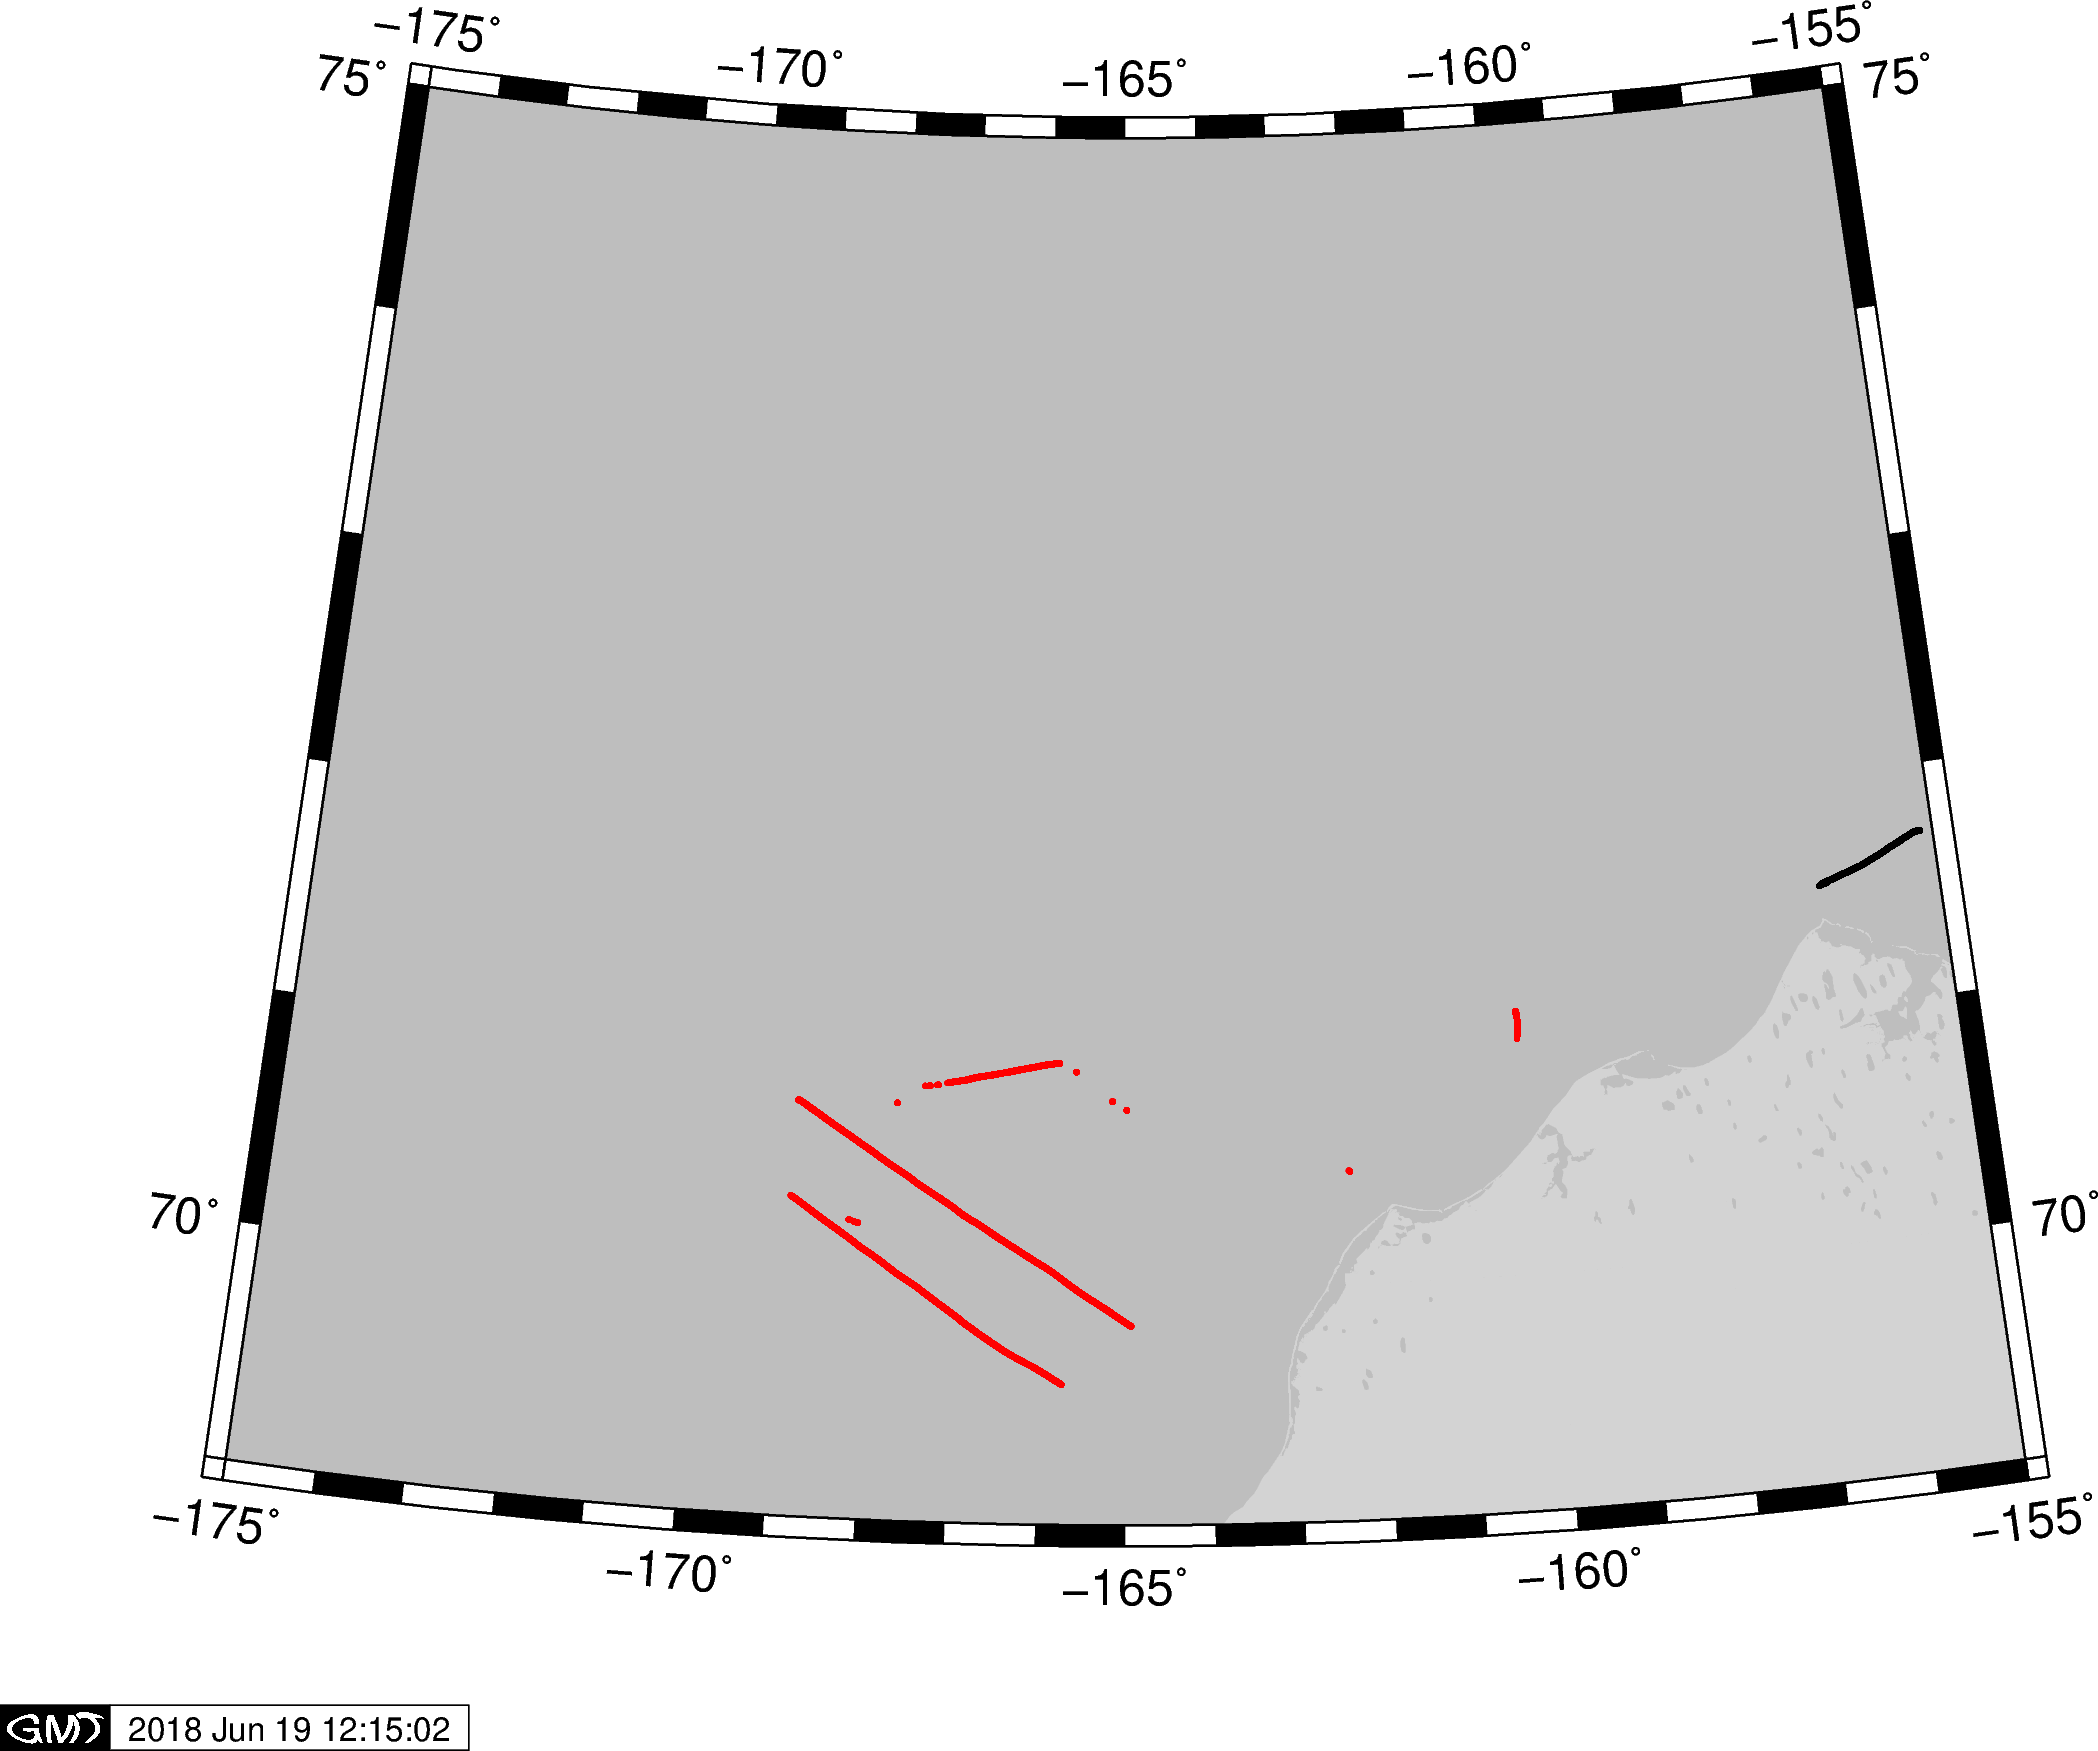

In [59]:
fig1.show()

In [60]:
import seawater
import cmocean

In [61]:
for cruise, df in dfs.items():
    df['Salinity'] = seawater.salt(r=10*df['Conductivity']/42.914,t=df['Temperature'],p=df['depth'])

No handles with labels found to put in legend.


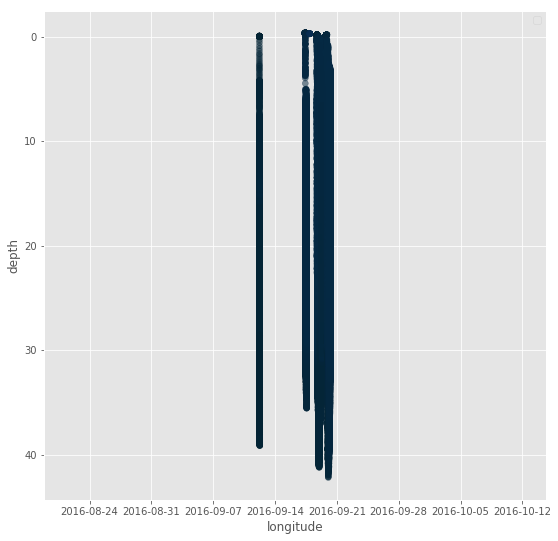

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

def xsections(df, ax):
    try:
        ax.scatter(df['2016-9'].index, df['depth']['2016-9'], c=df['Temperature']['2016-9'],
               cmap=cmocean.cm.thermal, alpha=0.5, label = '')
    except:
        pass
    
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()
#ax.set_xlim(['2016-09-07','2016-09-22'])

for cruise, df in dfs.items():
    xsections(df, ax)

leg = ax.legend()



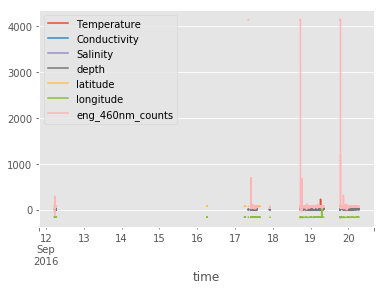

In [63]:
for cruise, df in dfs.items():
    try:
        df['2016-9'].plot()
    except:
        pass

No handles with labels found to put in legend.


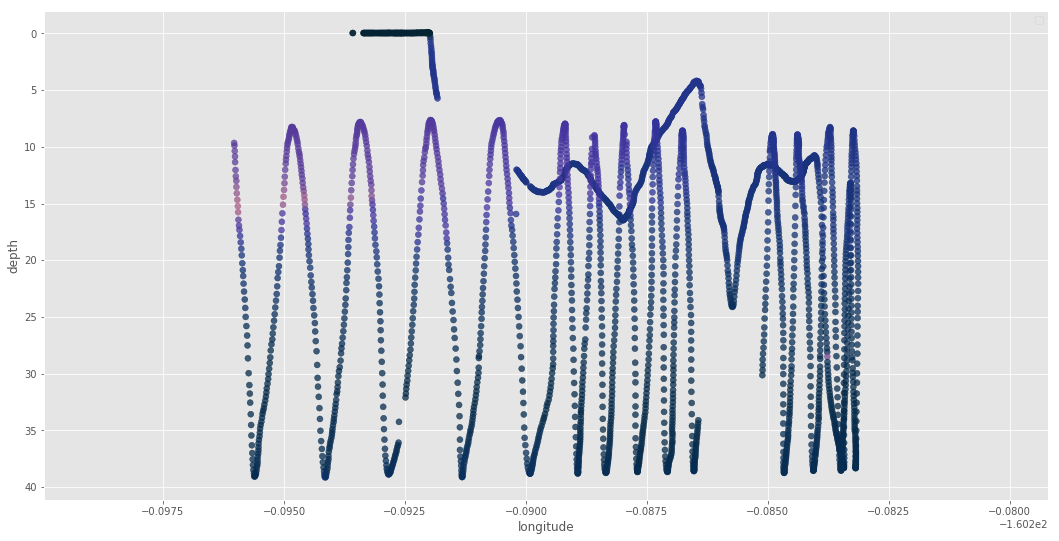

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

def xsections(df, ax, date):
    try:
        ax.scatter(df['longitude'][date], df['depth'][date], 
               c=df['Temperature'][date],
               cmap=cmocean.cm.thermal, vmin=-2, vmax=8, alpha=0.75, label = '')
    except:
        pass
    
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()

for cruise, df in dfs.items():
    xsections(df, ax, date='2016-9-12')

leg = ax.legend()



No handles with labels found to put in legend.


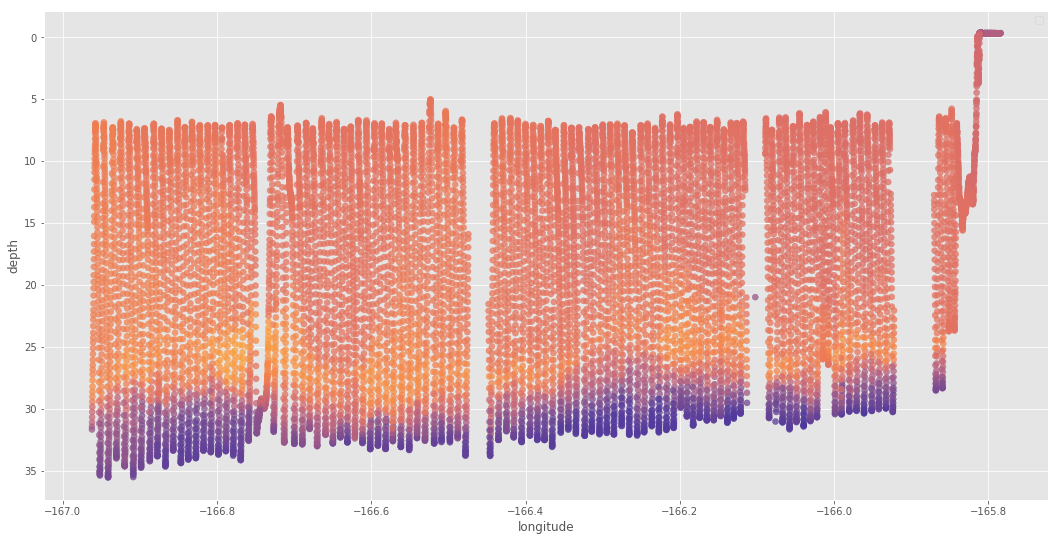

In [65]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()

for cruise, df in dfs.items():
    xsections(df, ax, date='2016-9-17')

leg = ax.legend()



In [66]:
%matplotlib inline
import matplotlib.pyplot as plt


def xsections(df, ax,variable,start,stop,vmin,vmax):
    if variable in ['Salinity']:
        cmap=cmocean.cm.haline
    elif variable in ['Temperature']:
        cmap=cmocean.cm.thermal
    elif variable in ['Chlorophyl','eng_695nm_counts']:
        cmap=cmocean.cm.algae
        
    try:
        ax.scatter(df['longitude'][start:stop], df['depth'][start:stop], 
               c=df[variable][start:stop],
               cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75, label = '')
    except:
        pass


No handles with labels found to put in legend.
No handles with labels found to put in legend.


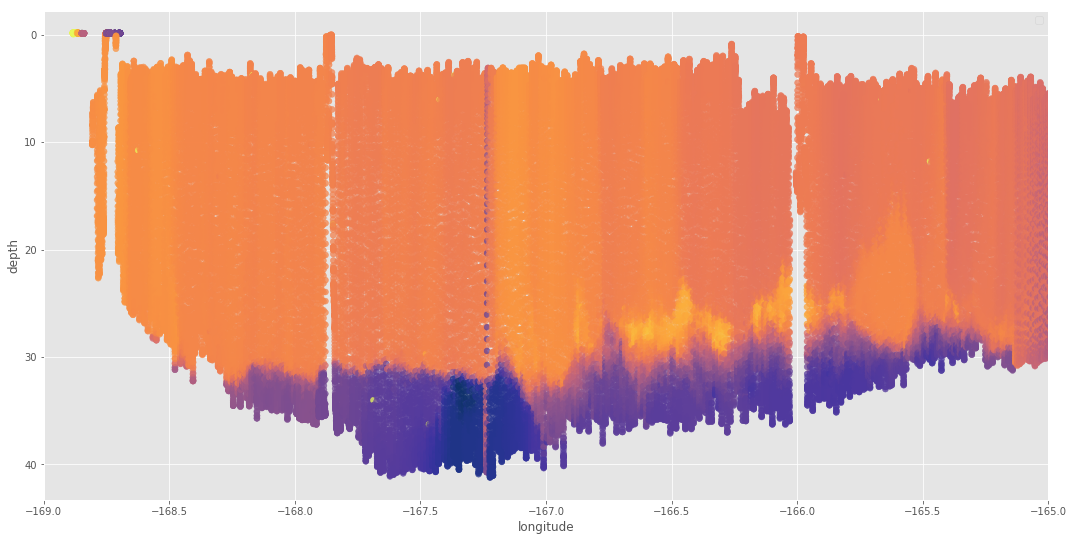

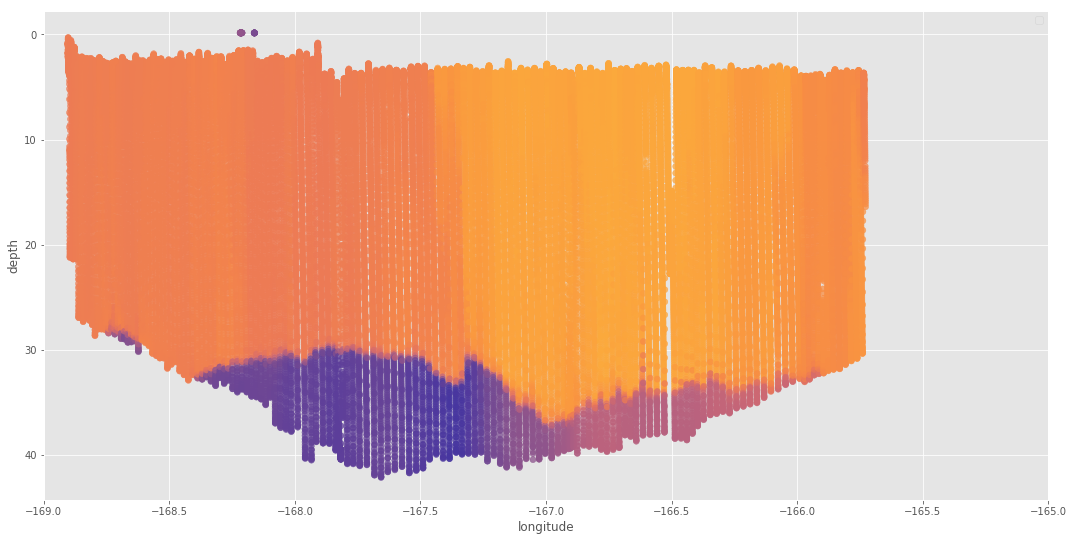

In [67]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()
ax.set_xlim([-169,-165])

for cruise, df in dfs.items():
    xsections(df, ax, variable='Temperature', start='2016-9-18', stop = '2016-9-19 12:00',vmin=-2,vmax=8)

leg = ax.legend()

    
fig2, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()
ax.set_xlim([-169,-165])

for cruise, df in dfs.items():
    xsections(df, ax, variable='Temperature', start='2016-9-19 12:00', stop = '2016-9-20 12:00',vmin=-2,vmax=8)

leg = ax.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


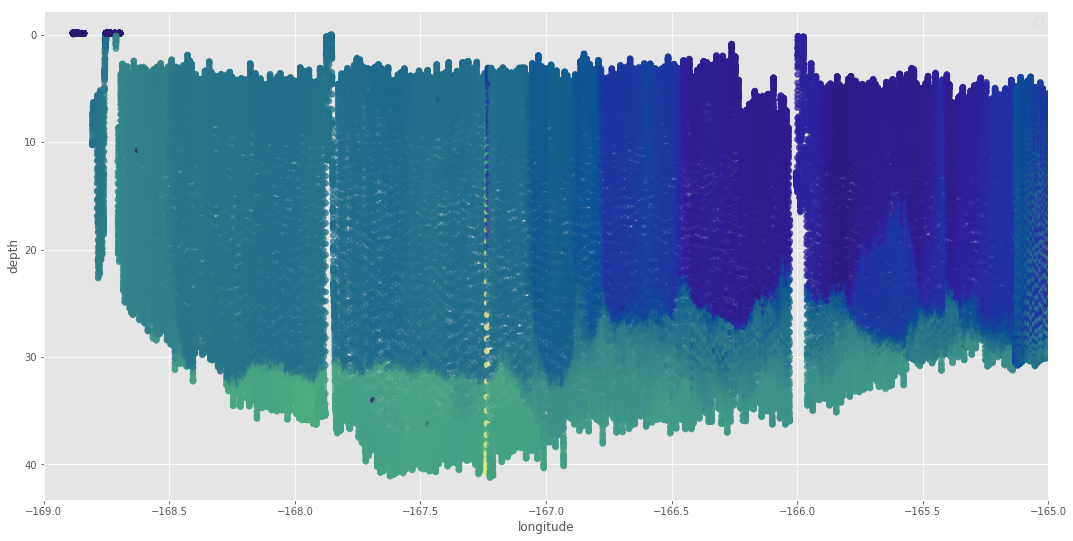

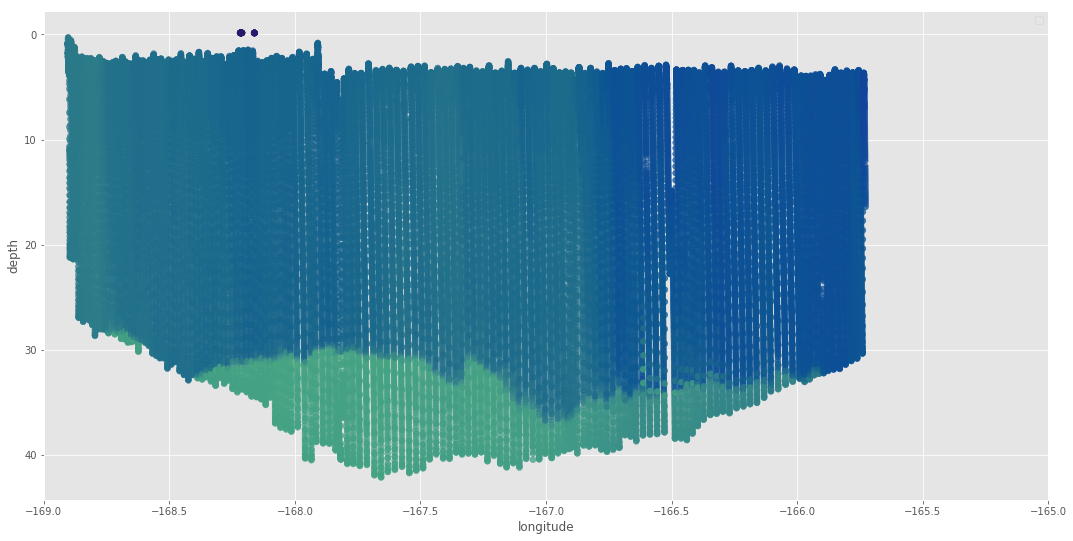

In [68]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()
ax.set_xlim([-169,-165])

for cruise, df in dfs.items():
    xsections(df, ax, variable='Salinity', start='2016-9-18', stop = '2016-9-19 12:00',vmin=30,vmax=34)

leg = ax.legend()

    
fig2, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()
ax.set_xlim([-169,-165])

for cruise, df in dfs.items():
    xsections(df, ax, variable='Salinity', start='2016-9-19 12:00', stop = '2016-9-20 12:00',vmin=30,vmax=34)

leg = ax.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


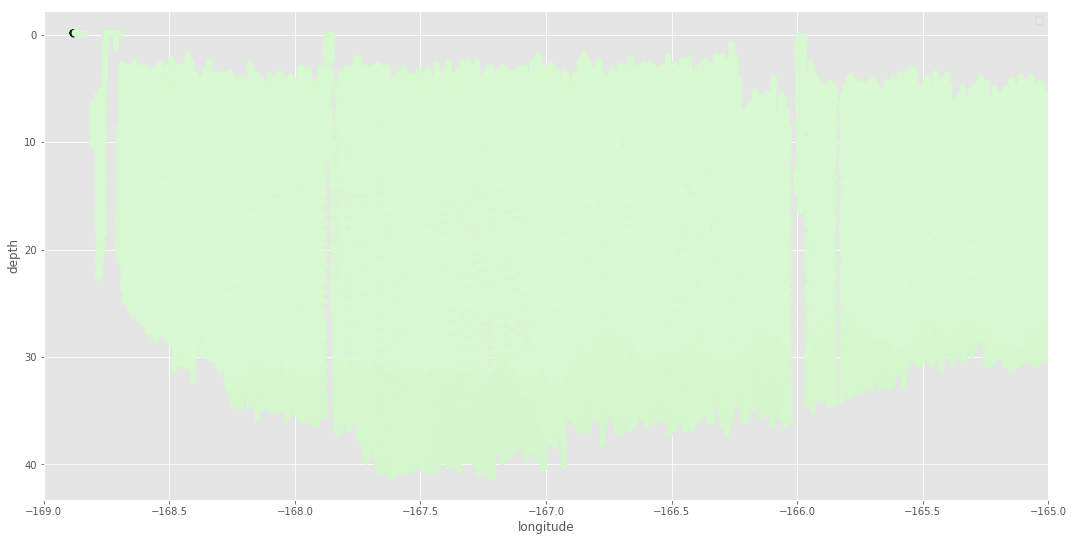

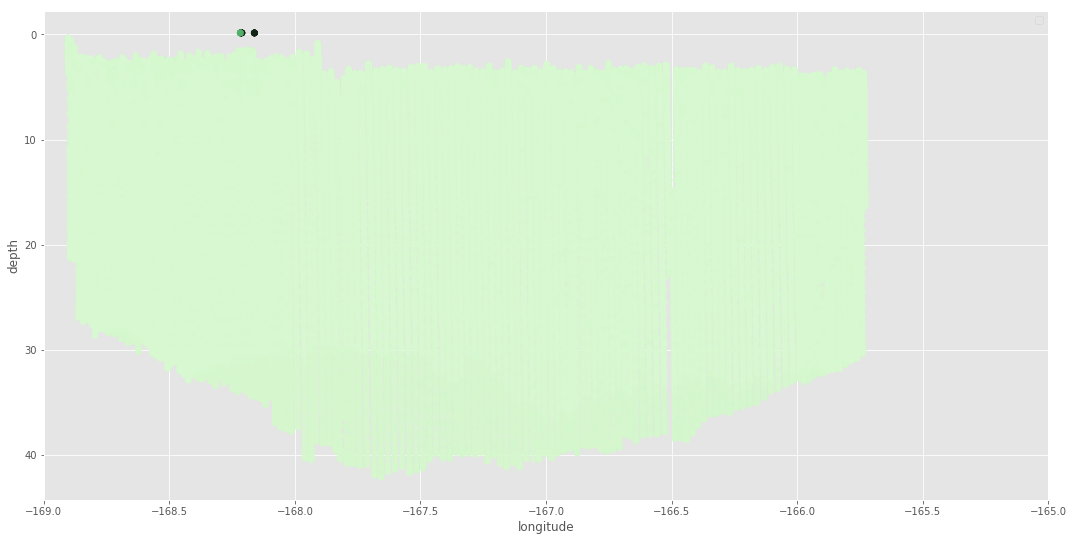

In [73]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()
ax.set_xlim([-169,-165])

for cruise, df in dfs.items():
    xsections(df, ax, variable='Chlorophyl', start='2016-9-18', stop = '2016-9-19 12:00',vmin=0,vmax=50)

leg = ax.legend()

    
fig2, ax = plt.subplots(figsize=(18, 9))
ax.set_ylabel('depth')
ax.set_xlabel('longitude')
ax.grid(True)
ax.invert_yaxis()
ax.set_xlim([-169,-165])

for cruise, df in dfs.items():
    xsections(df, ax, variable='Chlorophyl', start='2016-9-19 12:00', stop = '2016-9-20 12:00',vmin=0,vmax=50)

leg = ax.legend()

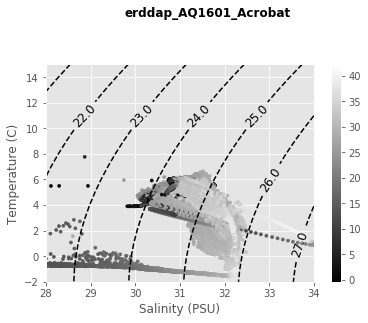

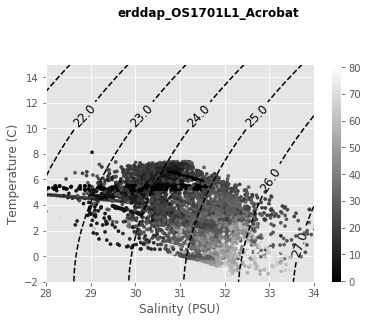

In [70]:
def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=seawater.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  

for cruise, df in dfs.items():
    plot_salvtemp(df['Salinity'],df['Temperature'],df['depth'],ptitle=cruise)



### Todo:

- Add Bathymetry
- ~~Add Chlorophyl~~
- Add Towfish stats